In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import imutils
from skimage.filters import threshold_otsu
import skimage.io as io
import math
import csv
from matplotlib.patches import Rectangle
import os

HOST = "192.168.125.5" #my IP address 
SERVER_PORT = 65432
FORMAT = "utf8" 

In [22]:
def neighbours(x,y,image): #for thining algorithm
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours): #for thining algorithm
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image): #main of thining algorithm
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
                    
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
            
        #Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

def min_thin_ver2(point_pos, mask_test, window_size = 21): # to extract size of pen point
    test_matrix = mask_test[int(point_pos[0]- (window_size-1)/2):int(point_pos[0] + (window_size-1)/2 + 1),
                            int(point_pos[1] - (window_size-1)/2):int(point_pos[1] + (window_size-1)/2 + 1)]
    #test_matrix = test_matrix.astype(int)
    sum_indices = window_size

    mask_1 = np.zeros([window_size,window_size], dtype="uint8")
    mask_1[:,int(window_size/2)] = 1

    mask_2 = np.zeros([window_size,window_size], dtype="uint8")
    mask_2[int(window_size/2),:] = 1
    # diagonal matrix
    mask_3 = np.eye(window_size,window_size)
    mask_3 = mask_3.astype(int)
    # sub diagonal matrix
    mask_4 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_4.shape)
    mask_4[i == window_size - 1 - j] = 1
    #window_size = 21
    mask_5 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_5.shape)
    mask_5[i-np.floor((window_size-2)/2) == window_size - j*2] = 1
    mask_5[1,14]=1
    mask_5[3,13]=1
    mask_5[5,12]=1
    mask_5[7,11]=1
    mask_5[9,10]=1
    mask_5[10,10]=1
    mask_5[11,10]=1
    mask_5[13,9]=1
    mask_5[15,8]=1
    mask_5[17,7]=1
    mask_5[19,6]=1
    #window_size = 21
    mask_6 = np.zeros([window_size,window_size], dtype="uint8")
    i,j = np.indices(mask_6.shape)
    #mask_6[i-np.floor((window_size-2)/2) == window_size - j*2] = 1
    mask_6[j-np.floor((window_size-2)/2) == window_size - i*2] = 1
    mask_6[5,19]=1
    mask_6[6,17]=1
    mask_6[7,15]=1
    mask_6[8,13]=1
    mask_6[9,11]=1
    mask_6[10,10]=1
    mask_6[11,9]=1
    mask_6[12,7]=1
    mask_6[13,5]=1
    mask_6[14,3]=1
    mask_6[15,1]=1

    mask_7 = np.flip(mask_6,0)
    mask_8 = np.flip(mask_5,0)

    mask_list = [mask_1, mask_2, mask_3, mask_4, mask_5, mask_6, mask_7, mask_8]
    for i in mask_list:
        tmp = sum(sum(test_matrix * i))
        if tmp < sum_indices:
            sum_indices = tmp
    return sum_indices

def calculate_distance(point1, point2): # tính khoảng cách 
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def find_points_with_value(matrix, value):# chuyển ma trận thành mảng các điểm 
    indices = np.argwhere(matrix == value)  
    return indices.tolist()

def choose_point(main, nearest_point, new_point): # chọn điểm gần nhất theo kim đồng hồ 
    if nearest_point[0] >= main[0] and new_point[0] >= main[0]:
        if nearest_point[1] > new_point[1]:
            return False
        else: 
            return True
    elif nearest_point[0] < main[0] and new_point[0] < main[0]:
        if nearest_point[1] < new_point[1]:
            return False
        else: 
            return True
    elif nearest_point[0] < main[0] and new_point[0] > main[0]:
        return True
    else: 
        return False

def add_nearest_point(new_points, points): #tìm điểm tiếp theo 
    min_distance = 0
    while min_distance <= 10 and len(points)>0:

        last_point = new_points[-1]
        nearest_point = points[0]
        min_distance = calculate_distance(last_point, nearest_point)
        
        for point in points:
            distance = calculate_distance(last_point, point)

            if distance < min_distance or (distance == min_distance and choose_point(last_point, nearest_point, point)):
                nearest_point = point
                min_distance = distance
        if nearest_point != new_points[-1] and min_distance <= 10 :
            new_points.append(nearest_point)

        points.remove(nearest_point)

def find_start_point(points,final, constant_distance, heso): # tìm điểm đầu tiên để bắt đầu
    if not points:
        return None
    min_point = points[0]
    min_distance = points[0][0]
    m =0
    n = constant_distance*heso[0] +50
    for point in points:
        if point[1] < n:
            m = 1
            break
        
    if m == 0:
        heso[0]+=1
        n = constant_distance*heso[0] +50
        for point in points:
            distance = point[0]
            if distance < min_distance and sum(sum(final[point[0]-1:point[0]+2,point[1]-1:point[1]+2])) <= 2 :
                min_point = point
                min_distance = distance
    else:
        min_distance = 1000
        for point in points:
                distance = point[0]
                if point[1] < n:
                    if distance < min_distance and sum(sum(final[point[0]-1:point[0]+2,point[1]-1:point[1]+2])) <= 3:
                        min_point = point
                        min_distance = distance
    #print("Khoảng cách: " ,min_distance, ", Điểm bắt đầu: ", min_point, ", hệ số n:", n, ", Điểm đầu tiên: ", points[0])
    return min_point

def final_points(final):
    constant_distance = 75 
    heso = [1] 

    all_points= find_points_with_value(final, value=1)
    new_points =[]
    raw_points =[]
    while all_points:
        start_point = find_start_point(all_points,final,constant_distance,heso)
        if start_point != None: 
            raw_points.append(start_point)
        add_nearest_point(raw_points, all_points)
        if len(raw_points) >3:
            new_points = new_points + raw_points
            new_points.append([21,21])
        raw_points =[]
        # print(new_points)
    return new_points

def final_points_rdp(final):
    constant_distance = 75 
    heso = [1] 

    all_points= find_points_with_value(final, value=1)
    new_points =[]
    raw_points =[]
    while all_points:
        start_point = find_start_point(all_points,final,constant_distance,heso)
        if start_point != None: 
            raw_points.append(start_point)
        add_nearest_point(raw_points, all_points)
        if len(raw_points) >3:
            new_points = new_points + rdp(raw_points, 1.5)
            new_points.append([21,21])
        raw_points =[]
        # print(new_points)
    return new_points

def create_coordination_visual(fontpath, text_input, row = 100, column = -40, horizontal = 200, height = 200): # create path for R-arm procedure
    mask = np.zeros([height,horizontal,3], dtype="uint8")
    
    font = ImageFont.truetype(fontpath,140)
    img_pil = Image.fromarray(mask)
    draw = ImageDraw.Draw(img_pil)
    draw.text((row, column),  text_input, font = font, fill = (0, 255, 0))

    img = np.array(img_pil)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    mask_ = np.full((height,horizontal), False)
    mask_[img != 0] = True

    final = zhangSuen(mask_)
    arr = final_points(final)
    mask_test = mask_.copy()
    plt.figure(figsize=(5,5), facecolor='black')
    plt.imshow(mask_test, cmap = "gray")
    plt.axis('off')
    plt.show()
    #print(min_thin(arr[0]))
    arr_thining = []
    for j, i in enumerate(arr):
        if j%1==0:
            arr_thining.append([i[0],i[1],min_thin_ver2(i,mask_test)])
    return arr_thining

def create_coordination_rdp(fontpath, text_input, row = 100, column = -40, horizontal = 200, height = 200): # create path for R-arm procedure
    mask = np.zeros([height,horizontal,3], dtype="uint8")
    
    font = ImageFont.truetype(fontpath,140)
    img_pil = Image.fromarray(mask)
    draw = ImageDraw.Draw(img_pil)
    draw.text((row, column),  text_input, font = font, fill = (0, 255, 0))

    img = np.array(img_pil)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    mask_ = np.full((height,horizontal), False)
    mask_[img != 0] = True

    final = zhangSuen(mask_)
    arr = final_points_rdp(final)
    mask_test = mask_.copy()
    #print(min_thin(arr[0]))
    arr_thining = []
    for j, i in enumerate(arr):
        if j%1==0:
            arr_thining.append([i[0],i[1],min_thin_ver2(i,mask_test)])
    return arr_thining

def rdp(points, epsilon):
    def line_length(point1, point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    def perpendicular_distance(point, line_start, line_end):
        if line_start == line_end:
            return line_length(point, line_start)
        n = abs(
            (line_end[0] - line_start[0]) * (line_start[1] - point[1]) -
            (line_start[0] - point[0]) * (line_end[1] - line_start[1])
        )
        d = line_length(line_start, line_end)
        return n / d

    def rdp_recursive(start_idx, end_idx):
        if end_idx - start_idx <= 1:
            return [points[start_idx], points[end_idx]]

        max_distance = 0
        farthest_point_index = 0
        line_start = points[start_idx]
        line_end = points[end_idx]

        for i in range(start_idx + 1, end_idx):
            distance = perpendicular_distance(points[i], line_start, line_end)
            if distance > max_distance:
                max_distance = distance
                farthest_point_index = i

        if max_distance > epsilon:
            left_segment = rdp_recursive(start_idx, farthest_point_index)
            right_segment = rdp_recursive(farthest_point_index, end_idx)
            return left_segment[:-1] + right_segment  # Exclude the duplicated point
        else:
            return [line_start, line_end]

    if len(points) < 2:
        return points
    return rdp_recursive(0, len(points) - 1)

def hienthi(trajectory):
    print(trajectory)
    arr = np.array(trajectory)

    # Tính toán phạm vi của dữ liệu
    x_min, x_max = np.min(arr[:, 0]), np.max(arr[:, 0])
    y_min, y_max = np.min(arr[:, 1]), np.max(arr[:, 1])

    # Tính toán kích thước hình vẽ dựa trên tỷ lệ giữa phạm vi x và y và một hệ số (vd: 0.1)
    x_range = x_max - x_min
    y_range = y_max - y_min
    aspect_ratio = y_range / x_range
    figsize = (5 * aspect_ratio, 5)

    plt.figure(figsize=figsize,facecolor='black')
    cl = 0
    cl_ = 0
    colors = np.array(["red", "green", "blue", "yellow", "orange", "purple", "gray", "magenta", "pink"])
    col_step_ = np.ceil(len(arr) / len(colors))
    col_step = col_step_
    for i in arr:
        if i[0] != 21:
            if cl > col_step:
                col_step += col_step_
                cl_ += 1
            plt.scatter([i[1]], [i[0]], color=colors[cl_], linewidths=0.1)
            cl += 1
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

def add_split(arr_thining): # add point[*,*,0] to split uncontinue line
   arr_thining_ = []
   #append first point with z = 0
   arr_thining_.append([arr_thining[0][0],arr_thining[0][1],0])




   for num in range(0,len(arr_thining)-1):
        if arr_thining[num][0] == 21 and  arr_thining[num][1] == 21:
            arr_thining_.append([arr_thining[num-1][0],arr_thining[num-1][1],0])
            arr_thining_.append([arr_thining[num+1][0],arr_thining[num+1][1],0])
        else :
            arr_thining_.append([arr_thining[num][0],arr_thining[num][1],arr_thining[num][2]])
   #append last point with z = 0
   arr_thining_.append([arr_thining[-2][0],arr_thining[-2][1],0])
   return arr_thining_

def calib(arr_thining_, h_origin = 135*1.2, w_origin= 80*1.2 , h_pixel = 900, w_pixel = 550):
   arr_thining_1 = arr_thining_.copy()
   arr_thining_2 = np.array(arr_thining_1)

   arr_thining_2[:,0] = (np.floor((arr_thining_2[:,0]/h_pixel)*h_origin)).astype(int)
   arr_thining_2[:,1] = (np.floor((arr_thining_2[:,1]/w_pixel)*w_origin)).astype(int)

   arr_Z = []

   for i in range(len(arr_thining_2[:,2])):
       if arr_thining_2[:,2][i] == 0:
           arr_Z.append(1)
       else:
           if int((arr_thining_2[:,2][i]-1)*(-11/25)) > -1:
               arr_Z.append(int(-1))
           elif int((arr_thining_2[:,2][i]-1)*(-11/25)) < -10:
               arr_Z.append(int(-10))
           else:
               arr_Z.append(int((arr_thining_2[:,2][i]-1)*(-11/25)))


         
   arr_thining_3 = np.stack((arr_thining_2[:,0],arr_thining_2[:,1],arr_Z), axis = 1)




   return arr_thining_3

def cvt_2_string(arr_int):
   arr_str = []
   for i in range( 0, len(arr_int)):
       arr_str.append(str(arr_int[i][0])+";"+str(arr_int[i][1])+";"+str(arr_int[i][2]))
   return arr_str


In [23]:
#lưu file
file_path = "/Users/anhduc/Documents/Project_Program/Final_Project/Thuc_nghiem"
main_split = add_split(main_trajectory)
main_calib = calib(main_split, h_origin = 290, w_origin= 290, h_pixel= 200,  w_pixel = 200)
main_str = cvt_2_string(main_calib)

with open(f"{file_path}/{text}", "w") as tep:
    for i in main_str:
        tep.write(i+"\n")

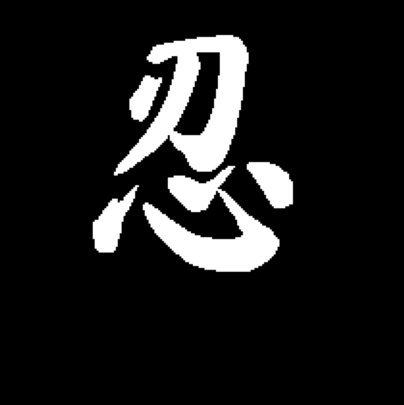

[[17, 101, 8], [17, 102, 8], [17, 103, 8], [17, 104, 8], [17, 105, 8], [17, 106, 8], [17, 107, 9], [17, 108, 9], [17, 109, 9], [17, 110, 9], [17, 111, 9], [17, 112, 8], [18, 113, 9], [19, 113, 10], [20, 114, 11], [21, 114, 11], [22, 114, 12], [23, 114, 12], [24, 115, 13], [25, 115, 13], [26, 115, 14], [27, 115, 14], [28, 115, 13], [29, 115, 13], [30, 115, 13], [31, 115, 13], [32, 115, 13], [33, 115, 13], [34, 114, 12], [35, 114, 12], [36, 114, 12], [37, 114, 12], [38, 114, 12], [39, 114, 12], [40, 114, 13], [41, 113, 12], [42, 113, 12], [43, 113, 12], [44, 113, 12], [45, 113, 12], [46, 113, 11], [47, 112, 12], [48, 112, 12], [49, 112, 12], [50, 112, 11], [51, 112, 11], [52, 111, 12], [53, 111, 12], [54, 111, 12], [55, 111, 11], [56, 111, 11], [57, 110, 12], [58, 110, 12], [59, 110, 11], [60, 109, 12], [61, 109, 11], [62, 109, 11], [63, 108, 12], [64, 108, 11], [65, 107, 12], [66, 107, 12], [67, 107, 12], [67, 106, 12], [68, 106, 12], [69, 106, 12], [69, 105, 12], [70, 105, 13], [71, 10

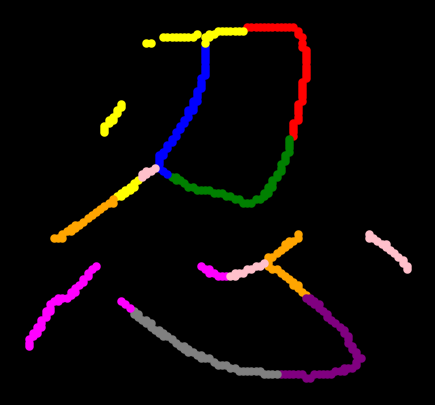

[[17, 101, 8], [17, 112, 8], [24, 115, 13], [46, 113, 11], [69, 106, 12], [72, 100, 16], [67, 87, 5], [61, 80, 12], [57, 80, 12], [40, 89, 9], [20, 91, 11], [18, 100, 8], [21, 21, 0], [19, 89, 9], [22, 77, 8], [21, 21, 0], [41, 71, 10], [50, 67, 11], [21, 21, 0], [65, 75, 10], [83, 55, 3], [21, 21, 0], [82, 113, 6], [89, 106, 5], [92, 106, 8], [112, 124, 9], [121, 128, 18], [124, 126, 13], [127, 116, 17], [125, 99, 13], [119, 87, 9], [103, 71, 4], [21, 21, 0], [92, 65, 1], [100, 60, 3], [104, 54, 8], [117, 49, 12], [21, 21, 0], [92, 90, 11], [95, 98, 15], [91, 105, 10], [21, 21, 0], [61, 79, 12], [64, 76, 10], [21, 21, 0], [82, 130, 8], [93, 139, 11], [21, 21, 0]]


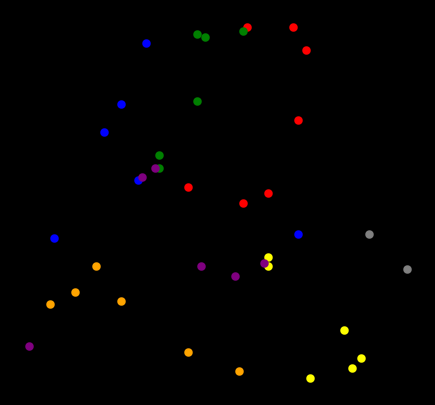

In [24]:
# 福 - 禄 - 寿 - 安 - 忍 - 德 - 心
# Phúc - Lộc - Thọ - An - Nhẫn - Đức - Tâm 
fontpath = '/Users/anhduc/Documents/Project_Program/Final_Project/font/MaShanZheng-Regular.ttf'
text = '忍'
x = 25
y = 0
hienthi(create_coordination_visual(fontpath, text, x, y))
main_trajectory = create_coordination_rdp(fontpath, text, x, y)
hienthi(main_trajectory)